# Death Statistics in Germany - Analysing the effects of Covid 19
### Project by Nicole Rogalla and Lisa Artmann

> The goal of our project is to analyze the death statistics in Germany with respect to Covid-19, specifically the effect on the total number of deaths, other causes of death, life expectancy and demographics.

In [12]:
from os import stat
import pandas as pd
import io
import codecs
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

# Cleaning the Dataset

In [13]:
stat =pd.read_csv("ds.csv", encoding = 'cp1252', sep = ";", header = 7)
stat.head()

,Unnamed: 0,Unnamed: 1,männlich,männlich.1,männlich.2,männlich.3,männlich.4,männlich.5,männlich.6,männlich.7,...,weiblich.8,weiblich.9,weiblich.10,weiblich.11,weiblich.12,weiblich.13,weiblich.14,weiblich.15,weiblich.16,weiblich.17
0,NaN,NaN,Altersgruppen,Altersgruppen,Altersgruppen,Altersgruppen,Altersgruppen,Altersgruppen,Altersgruppen,Altersgruppen,...,Altersgruppen,Altersgruppen,Altersgruppen,Altersgruppen,Altersgruppen,Altersgruppen,Altersgruppen,Altersgruppen,Altersgruppen,Altersgruppen
1,NaN,NaN,unter 1 Jahr,1 bis unter 15 Jahre,15 bis unter 20 Jahre,20 bis unter 25 Jahre,25 bis unter 30 Jahre,30 bis unter 35 Jahre,35 bis unter 40 Jahre,40 bis unter 45 Jahre,...,45 bis unter 50 Jahre,50 bis unter 55 Jahre,55 bis unter 60 Jahre,60 bis unter 65 Jahre,65 bis unter 70 Jahre,70 bis unter 75 Jahre,75 bis unter 80 Jahre,80 bis unter 85 Jahre,85 Jahre und mehr,Alter unbekannt
2,2017,Bestimmte infektiöse und parasitäre Krankheiten,10,20,5,12,11,28,50,78,...,52,136,174,259,364,550,1157,1772,4502,-
3,2017,Tuberkulose einschließlich ihrer Folgezustände,-,-,-,1,2,-,6,3,...,-,1,1,6,3,8,23,19,54,-
4,2017,Meningokokkeninfektion,1,3,-,2,-,-,-,-,...,-,2,1,1,1,-,1,3,-,-


From a Data Analysis point of view the dataset is very unstructured and needs to be rearranged and cleaned before further analysis. We want to transform the dataset in a way that we end up with one column for:
 - the year
 - age group
 - sex
 - the number of deaths
 - Cause of death

In [14]:
def clean_data(stat) : 
    """Cleans the ds.csv dataset"""
    
    # The Dataset ends after 330 lines 
    stat = stat[:330]
    stat = stat.rename(columns = {"Unnamed: 0" : "Jahre", "Unnamed: 1" : "Todesursachen"})
    # unavailable values are replaced by 0
    stat = stat.replace("-", 0)
    stat = stat.replace(".", 0)
    
    # columns with unknown age are removed
    stat = stat.drop('weiblich.17', axis = 1)
    stat = stat.drop("männlich.17", axis = 1)
    
    # merges rows concerning the agegroup
    for i in range(0,36):
        stat.iloc[0,i] = stat.iloc[0,i]  + stat.iloc[1,i]
    #deletes row with now redundant information on agegroup
    stat = stat.drop(1, axis = 0)
    #unpivots columns regarding agegroup and gender
    stat = stat.melt(id_vars = ['Jahre', 'Todesursachen'], value_vars = stat.drop(['Jahre', 'Todesursachen'], axis = 1))
    # splits unpivoted value column to seperate the values from the agegroup information
    value_split = stat[stat.columns[3]].str.split("Altersgruppen",expand = True)
    stat[["value", "Altersgruppe"]] = value_split
    
    stat[["Altersgruppe"]] = stat[["Altersgruppe"]].ffill()
    stat[["value"]] = stat[["value"]].fillna(0)
    
    stat = stat.rename(columns = {"variable" : "Geschlecht"})
    
    # removes the number from the "Geschlecht" column
    stat_Geschlecht = stat[stat.columns[2]].str.split(".",expand = True) 
    stat[["Geschlecht"]] = stat_Geschlecht[[0]]
    # drops first row
    stat = stat.drop(0, axis = 0)
    stat = stat.dropna()

    
    stat[["value"]] = stat[["value"]].astype(int)
    
    # Since some values are counted in the superordinate category and the subordinate category, 
    # we specified the superordinate categories to filter and reduce duplication.
    # Since the Subcagetories do not always add up to the supercategories, we selected the supercategories 
    causes = ["Bestimmte infektiöse und parasitäre Krankheiten", 
              "Neubildungen", 
              "Krankheiten des Blutes u. der blutbildenden Organe", 
              "\"Endokrine, Ernährungs- u. Stoffwechselkrankheiten\"",
              "Psychische und Verhaltensstörungen", 
              "Krankheiten d. Nervensystems u. d. Sinnesorgane", 
              "Meningitis", 
              "Krankheiten des Kreislaufsystems",
              "Zerebrovaskuläre Krankheiten",
              "Krankheiten des Atmungssystems",
              "COVID-19, Virus nachgewiesen", 
              "COVID-19, Virus nicht nachgewiesen", 
              "Krankheiten des Verdauungssystems", 
              "Krankheiten der Leber", 
              "Krankheiten der Haut und der Unterhaut",
              "Krankh. des Muskel-Skelett-Systems u. Bindegewebes",
              "Krankheiten des Urogenitalsystems", 
              "\"Schwangerschaft, Geburt und Wochenbett\"", 
              "Best.Zustände mit Ursprung in der Perinatalperiode", 
              "\"Angeb. Fehlbildungen,DeformitÃ¤ten,Chromosomenanom.\"",
              "Symptome und abnorme klinische und Laborbefunde", 
              "Plötzlicher Kindstod", 
              "Sonst. ungenau bezeichnete u. unbek. Todesursachen", 
              "Äußere Ursachen von Morbidität und Mortalität", 
              "Vorsätzliche Selbstbeschädigung", 
              "Tätlicher Angriff", 
              "Ereignis, dessen nähere Umstände unbestimmt sind" ]
    stat = stat[stat["Todesursachen"].isin(causes) ]
    stat[stat["Todesursachen"] == "Krankeiten des Atmungssystems"] = stat[stat["Todesursachen"] == "Krankeiten des Atmungssystems"] - stat[(stat["Todesursachen"].str.contains("COVID")) == True]
    return stat

In [15]:
stat_cleaned = clean_data(stat)
stat_cleaned.head()

,Jahre,Todesursachen,Geschlecht,value,Altersgruppe
1,2017,Bestimmte infektiöse und parasitäre Krankheiten,männlich,10,unter 1 Jahr
6,2017,Neubildungen,männlich,13,unter 1 Jahr
31,2017,Krankheiten des Blutes u. der blutbildenden Or...,männlich,8,unter 1 Jahr
34,2017,Psychische und Verhaltensstörungen,männlich,1,unter 1 Jahr
37,2017,Krankheiten d. Nervensystems u. d. Sinnesorgane,männlich,22,unter 1 Jahr


# Overview Plot from 2017 - 2020

In [16]:
def overviewPlot(stat_cleaned):
    """Plots the top causes of death 2017-2020"""
    # extracts the top causes of death
    top_ursachen = stat_cleaned.groupby(["Jahre", "Todesursachen"])["value"].sum().reset_index().sort_values(by ="value",ascending = False)
    top_urs = top_ursachen.head(20)
    # extracts covid from the dataset
    cov = top_ursachen[top_ursachen["Todesursachen"].str.contains("COVID")].groupby("Jahre")["value"].sum().reset_index()
    cov["Todesursachen"]= ["COVID", "COVID", "COVID", "COVID"]
    # All other causes are counted towards "Sonstige"
    sonst = top_ursachen[4:]
    sonst = sonst[(sonst["Todesursachen"].str.contains("COVID")) == False]
    sonst = sonst.groupby("Jahre")["value"].sum().reset_index()
    sonst["Todesursachen"]= ["Sonstige", "Sonstige", "Sonstige", "Sonstige"]
 
    # concatinates the top causes, covid and sonstige
    top_urs = pd.concat([cov,top_urs, sonst]).reset_index()
   
    # creates the plot
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(10)
    sns.set_theme(palette = "pastel")
    sns.histplot(data = top_urs, x = "Jahre",weights = "value", hue = "Todesursachen",multiple = "stack")
    plt.title("Gesamtzahl der Todesfälle pro Jahr")
    plt.ylabel("Anzahl der Todesfälle")
    plt.show()



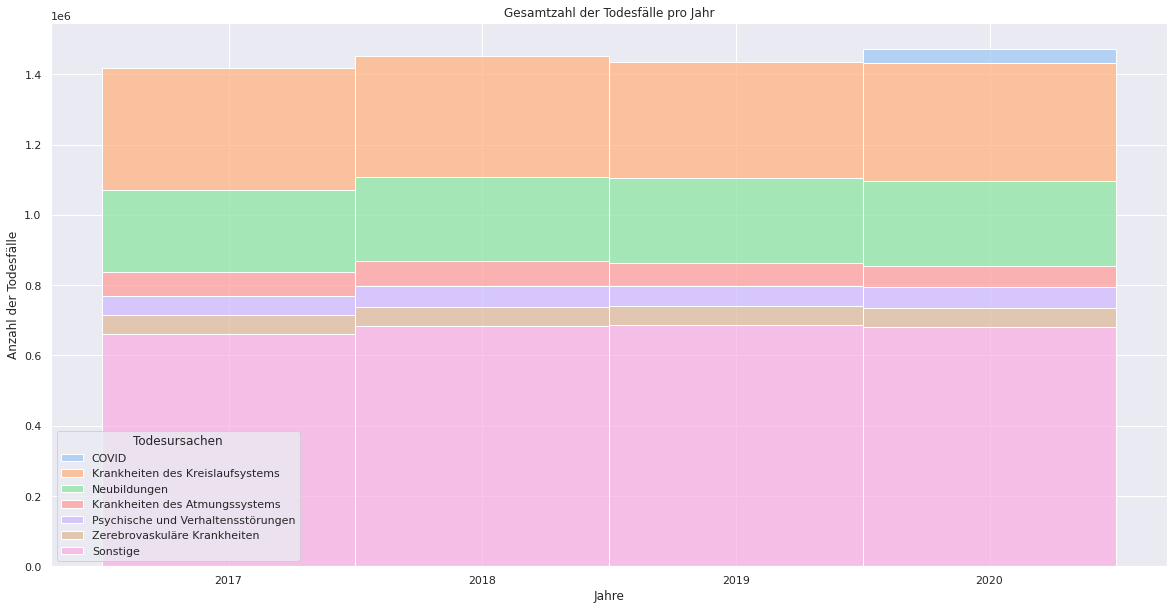

In [17]:
overviewPlot(stat_cleaned)

This Plot gives you an overview of the dataset and shows the main causes of death among the years. Overall, it seems like cardiovascular diseases are the main cause of death. Additionally, more people died in 2020 compared to the previous years. If that is due to covid remains to be seen...

# Compare Total Number of Deaths

In [18]:
def compareTotalNumberOfDeath(stat_cleaned):
    """prints the factor by which the number of deaths has increased in 2020 compared to the mean of the 3 preceeding years"""

    stat_total =stat_cleaned.groupby(["Jahre"])["value"].sum().reset_index()
    mean_before_covid =np.mean(stat_total[:3]["value"])
    after_vs_before = stat_total.iloc[[3]]["value"]/mean_before_covid
    print("The factor by which the number of deaths has increased in 2020 compared to the mean of the 3 preceeding years: ")
    print(after_vs_before[3])

In [19]:
def compareNmberOfDeathsPerAgegroup(stat_cleaned):
    """Plots the mean of deaths per age group before and after covid started"""
    
    # exclueds 2020 and determines the mean
    stat_total_age =stat_cleaned[(stat_cleaned["Jahre"]== '2020') == False].groupby([ "Altersgruppe"])["value"].sum().reset_index()
    stat_total_age["value"] = (stat_total_age["value"]/3)
    stat_total_age = stat_total_age.rename(columns ={"value": "2017 - 2019"})
    
    # determines the number in 2020
    stat_total_age["2020"] = stat_cleaned[(stat_cleaned["Jahre"]== '2020') ].groupby([ "Altersgruppe"])["value"].sum().reset_index()["value"]
    stat_total_age = stat_total_age.melt(id_vars = ['Altersgruppe'], value_vars = ['2017 - 2019', "2020"])
    #stat_total_age = stat_total_age.sort_values(by = ["value"])
    
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(10)
    sns.set_theme(style = "ticks", palette = "pastel")
    chart = sns.barplot(data = stat_total_age, x = "Altersgruppe",y = "value", hue = "variable")
    chart.set_xticklabels(chart.get_xticklabels(), rotation = 45,horizontalalignment = 'right')
    plt.title("Gesamtzahl an Todesfällen pro Altersgruppe")
    plt.ylabel("Anzahl an Todesfällen")
    plt.show()

In [20]:
 # compare number of deaths per disease
def compareNumberOfDeathsPerDisease(todesursache):
    
    """Plots the mean of deaths per cause before and after covid started"""
    stat = pd.read_csv("ds.csv", encoding = 'cp1252', sep = ";", header = 7)
    stat_cleaned = clean_data(stat)
    
    stat_cleaned = stat_cleaned[stat_cleaned['Todesursachen'] == todesursache]
    
    # exclueds 2020 and determines the mean
    
    stat_total_cause =stat_cleaned[(stat_cleaned["Jahre"]== '2020') == False].groupby([ "Todesursachen"])["value"].sum().reset_index()
    stat_total_cause["value"] = (stat_total_cause["value"]/3)
    stat_total_cause = stat_total_cause.rename(columns ={"value": "2017 - 2019"})
    
    
    # determines the number in 2020
    stat_total_cause["2020"] = stat_cleaned[(stat_cleaned["Jahre"]== '2020')].groupby([ "Todesursachen"])["value"].sum().reset_index()["value"]
    stat_total_cause = stat_total_cause.melt(id_vars = ["Todesursachen"], value_vars = ['2017 - 2019', "2020"])
    stat_total_cause = stat_total_cause.sort_values(by = ["value"])
    
    
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(10)
    sns.set_theme(style = "ticks", palette = "pastel")
    chart = sns.barplot(data = stat_total_cause, x = "Todesursachen",y = "value", hue = "variable")
    plt.title("Gesamtzahl an Todesfällen pro Todesursache")
    plt.ylabel("Anzahl an Todesfällen")
    plt.show()

In [21]:
#stat_total_cause.head(20)
compareTotalNumberOfDeath(stat_cleaned)

The factor by which the number of deaths has increased in 2020 compared to the mean of the 3 preceeding years: 
1.0415181915177818


# Deaths per Age Group 

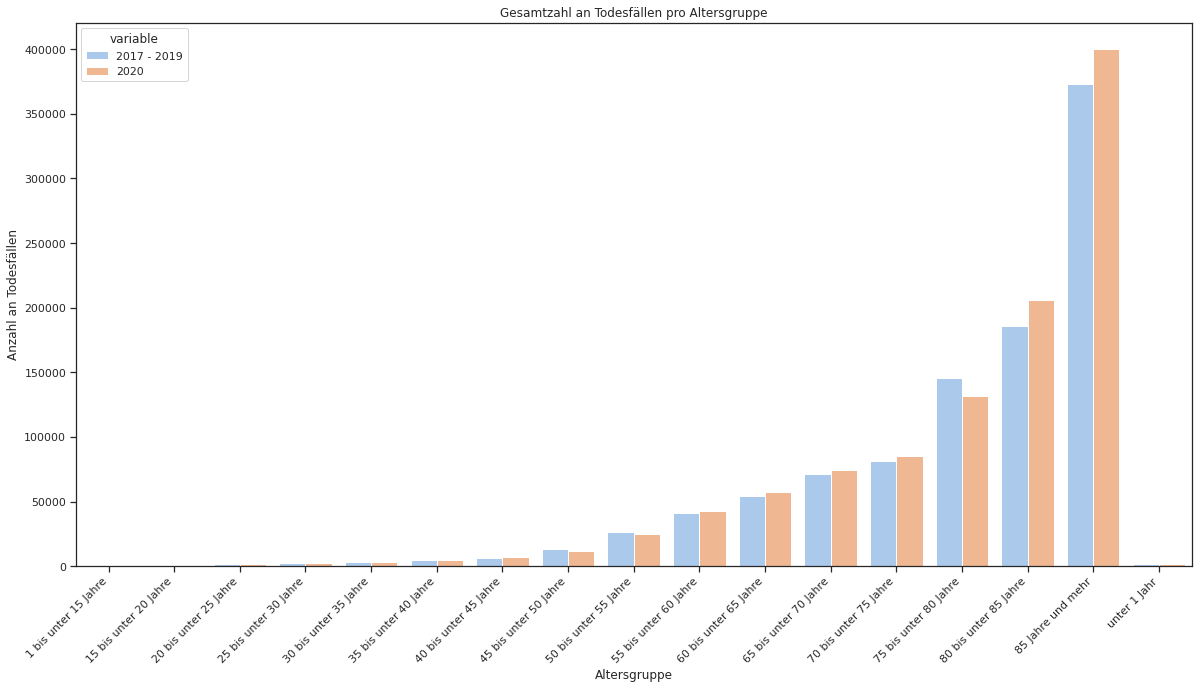

In [22]:
compareNmberOfDeathsPerAgegroup(stat_cleaned)

In most age groups more people died in 2020 compared to 2019. One exception is the age group 75 to 80 years where the total number of deaths has declined compared to the mean of the years before. This could have multiple reasons like measures against covid or demographic change which we will have a look at later on. 

# Deaths per cause of death

In [23]:
a = stat_cleaned.groupby("Todesursachen")["value"].sum().reset_index()["Todesursachen"]

drop = widgets.Dropdown(options = a)

widgets.interact(compareNumberOfDeathsPerDisease, todesursache = drop)

interactive(children=(Dropdown(description='todesursache', options=('Best.Zustände mit Ursprung in der Perinat…

<function __main__.compareNumberOfDeathsPerDisease(todesursache)>

Overall, it seems like most other causes declined in 2020 even though most are probably not statistically significant. The largest decrease can be observed for respiratory diseases (other than covid) and infectious and parasitic diseases.

# Cause with the biggest difference between before and after Covid by Age Groupe

In [34]:
def InteractiveAgePlot(altersgruppe):
    global data_for_later
    
    stat =pd.read_csv("ds.csv", encoding = 'cp1252', sep = ";", header = 7)
    stat_cleaned = clean_data(stat)
    
    # exclude Covid
    stat_cleaned = stat_cleaned[(stat_cleaned["Todesursachen"].str.contains("COVID")) == False]
    stat_cleaned = stat_cleaned[stat_cleaned["Altersgruppe"] == altersgruppe]

    # get the 2017 - 2019 (2017-2019) and create new column
    stat_total_cause =stat_cleaned[(stat_cleaned["Jahre"]== '2020') == False].groupby(["Altersgruppe", "Todesursachen"])["value"].sum().reset_index()
    stat_total_cause["value"] = (stat_total_cause["value"]/3)
    stat_total_cause = stat_total_cause.rename(columns ={"value": "2017 - 2019"})
    stat_total_cause["2020"] = stat_cleaned[(stat_cleaned["Jahre"]== '2020') ].groupby(["Altersgruppe", "Todesursachen"])["value"].sum().reset_index()["value"]

    # create column with the difference before and after covid
    stat_total_cause["difference"] = abs(stat_total_cause["2020"] - stat_total_cause["2017 - 2019"])
    data_for_later = stat_total_cause # safe data for later
    max_diffs = stat_total_cause.groupby(["Altersgruppe"])["difference"].max().reset_index()


    stat_max_diffs = pd.DataFrame()
    # merges max difference with the dataset
    for m in max_diffs.itertuples():  
        stat_max_diffs = pd.concat([stat_max_diffs,stat_total_cause.loc[(stat_total_cause["Altersgruppe"] == m[1]) & (stat_total_cause["difference"] == m[2])]], ignore_index = True)
    stat_max_diffs = stat_max_diffs.melt(id_vars = ["Altersgruppe","Todesursachen"], value_vars = ['2017 - 2019', "2020"])
    
    sns.set_theme(style = "ticks", palette = "pastel")
    sns.catplot( data = stat_max_diffs, x = "Altersgruppe", y = "value", hue = "variable", kind = "bar").set(title=stat_max_diffs["Todesursachen"][0])
    plt.ylabel("Anahl an Todesfällen")
    plt.show()


In [35]:
a = stat_cleaned.groupby("Altersgruppe")["value"].sum().reset_index()["Altersgruppe"]

drop = widgets.Dropdown(options = a)

widgets.interact(InteractiveAgePlot, altersgruppe = drop)

interactive(children=(Dropdown(description='altersgruppe', options=('1 bis unter 15 Jahre', '15 bis unter 20 J…

<function __main__.InteractiveAgePlot(altersgruppe)>

In this Plot you can select the age group and then find out which disease have the major difference between before and after covid onset.

# Covid and life expectency 

In this section we want to investigate the effects of covid on general life expectency

In [26]:
sterberate = pd.read_csv("periodensterberate.csv", encoding = 'cp1252', sep = ";", header = 6)
sterberate.head()

,Unnamed: 0,Unnamed: 1,2016/18,2017/19,2018/20,2019/21
0,männlich,0 Jahre,"78,48","78,63","78,64","78,54"
1,männlich,1 Jahr,"77,76","77,90","77,90","77,80"
2,männlich,2 Jahre,"76,78","76,92","76,92","76,81"
3,männlich,3 Jahre,"75,79","75,93","75,93","75,82"
4,männlich,4 Jahre,"74,80","74,94","74,94","74,83"


The dataset needs some cleaning and further processing to determine the difference between the time intervals.

Text(0, 0.5, 'Unterschied der Lebenserwartung in Jahren')

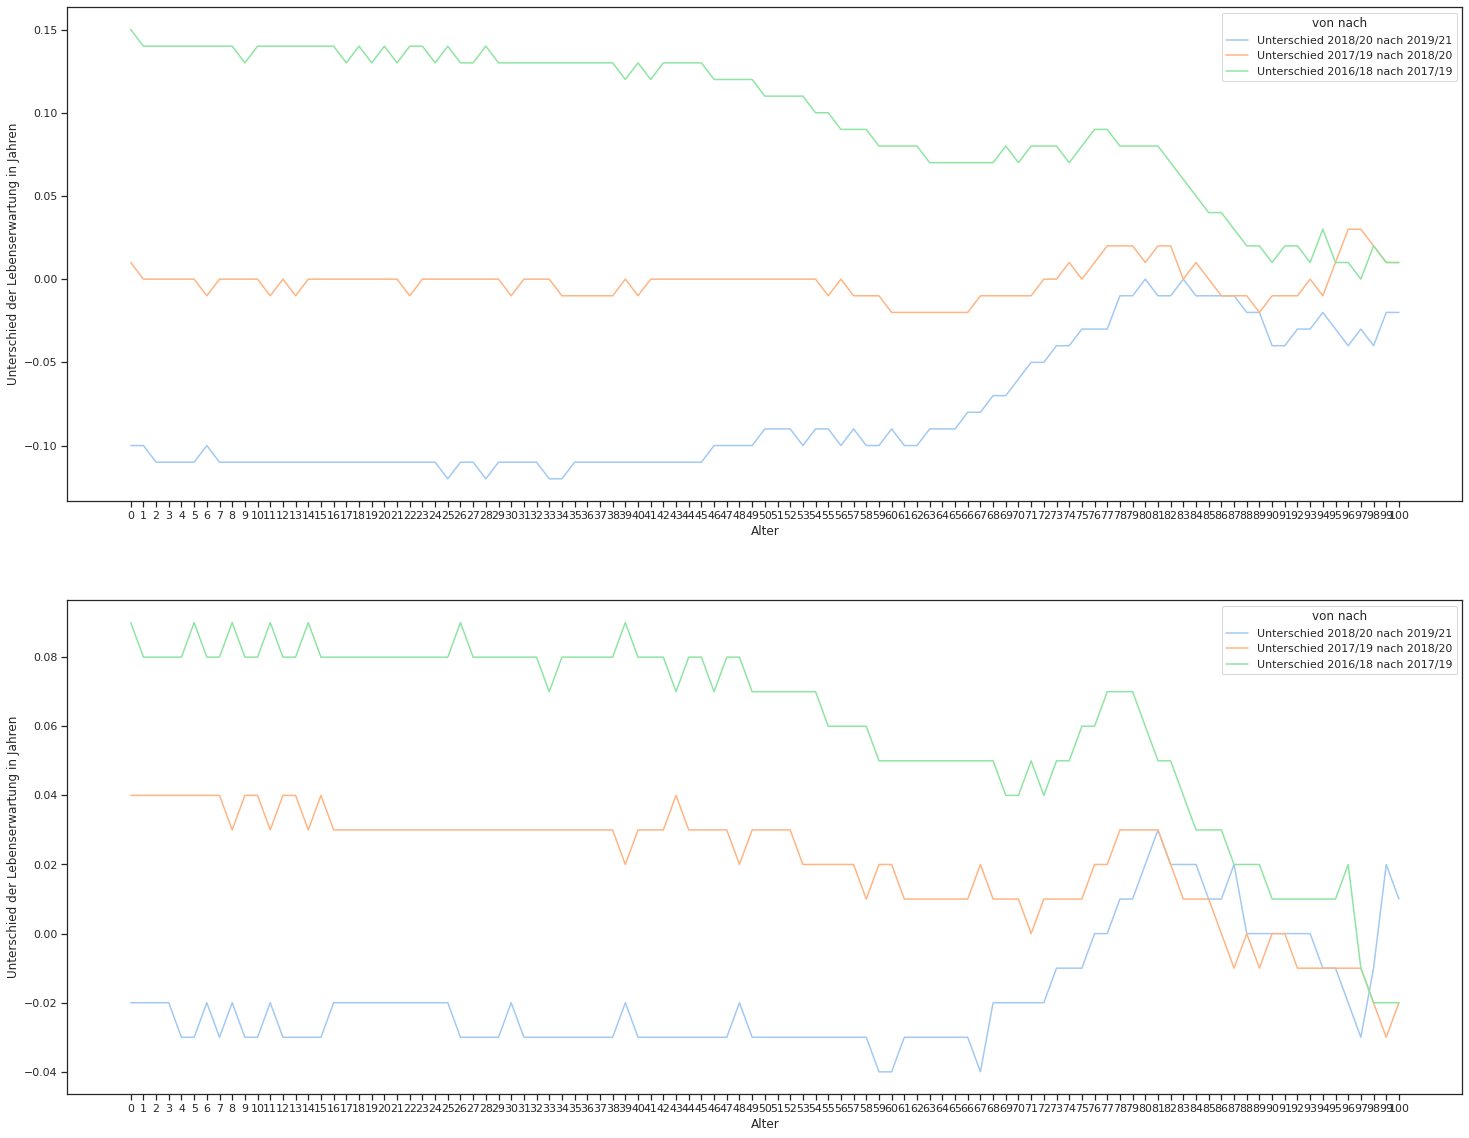

In [27]:
sterberate = sterberate[:202]
sterberate = sterberate.rename(columns = {"Unnamed: 0" : "Geschlecht", "Unnamed: 1" : "Alter"})

# converts date columns and calculates difference
sterberate["Unterschied 2018/20 nach 2019/21"] = sterberate["2019/21"].str.replace(",", ".").astype(float) - sterberate["2018/20"].str.replace(",", ".").astype(float)
sterberate["Unterschied 2017/19 nach 2018/20"] = sterberate["2018/20"].str.replace(",", ".").astype(float) - sterberate["2017/19"].str.replace(",", ".").astype(float)
sterberate["Unterschied 2016/18 nach 2017/19"] = sterberate["2017/19"].str.replace(",", ".").astype(float) - sterberate["2016/18"].str.replace(",", ".").astype(float)

age = sterberate["Alter"].str.split(" ", expand = True)
sterberate["Alter"] = age[0]

sterberate = pd.melt(
    sterberate,
    id_vars = ["Geschlecht", "Alter"], 
    value_vars = ["Unterschied 2018/20 nach 2019/21", "Unterschied 2017/19 nach 2018/20", "Unterschied 2016/18 nach 2017/19"])


sterberate = sterberate.rename(columns = {"variable" : "von nach", "value" : "Unterschied"})

f, axes = plt.subplots(2,1,  figsize=(25, 20))
sns.set_theme(style = "ticks", palette = "pastel")

g1 = sns.lineplot( 
    data = sterberate[sterberate["Geschlecht"] == 'männlich'], 
    x = "Alter", 
    y = "Unterschied", 
    hue = "von nach",  
    ax = axes[0])

g2 = sns.lineplot( 
    data = sterberate[sterberate["Geschlecht"] == 'weiblich'], 
    x = "Alter", 
    y = "Unterschied", 
    hue = "von nach",  
    ax = axes[1])

g1.set_ylabel("Unterschied der Lebenserwartung in Jahren")
g2.set_ylabel("Unterschied der Lebenserwartung in Jahren")

The green line depicts the life expectency for a time where covid was not yet present. The red line depicts the change from a covid free time to the covid onset and the blue line depicts the change from the first year of covid to the second year of covid. 

In general, the difference in life expectancy seems to be greater in males compared to females (0.08 vs 0.15 and -0.02 vs -0.1). It can clearly be seen that the life expectancy decreased when comparing "before covid" to "after covid" in the ages 0-75. For people older than 75 this difference does not become so apparent and especially for females the life expectency does even seem to have increased. While that may seem odd at first, reasons for that could be that all the measures taken to protect the elderly lead to a reduction of other causes of death such as for example catching the flu. 

# How the demographics changed after Covid

In [28]:
population = pd.read_csv("age.csv", encoding = 'cp1252', sep = ";", header = 6)
population.head()

,Unnamed: 0,31.12.2017,31.12.2018,31.12.2019,31.12.2020,31.12.2021
0,unter 1 Jahr,785074.0,783978.0,774870.0,769380.0,791254.0
1,1-Jährige,796149.0,796374.0,794132.0,783593.0,780795.0
2,2-Jährige,770628.0,802651.0,802415.0,798366.0,789145.0
3,3-Jährige,760868.0,776763.0,807816.0,806198.0,803334.0
4,4-Jährige,734059.0,766631.0,782143.0,811601.0,810805.0


First we calculate the differences betweeen the years we want to look at and then clean the dataset. Additionally, we add an age group column in order to make the dataset comparable to the first dataset. 

In [29]:
def clean_data2(population):

    # calculate difference between 2020 and 2019 and the mean between 2019 and 2017
    population["difference2020-2019"] = population["31.12.2020"] - population["31.12.2019"]
    population["difference2019-2017"] = (population["31.12.2019"] - population["31.12.2018"] + population["31.12.2018"] - population["31.12.2017"])/2 

    population = population.drop(["31.12.2017", "31.12.2018", "31.12.2021", "31.12.2020", "31.12.2019"], axis = 1)

    # conversion of age column to an integer Series
    population = population.dropna()
    population = population[population["Unnamed: 0"] != "Insgesamt"]
    population["Unnamed: 0"] = population["Unnamed: 0"].str.replace("unter 1 Jahr", "0")
    population["Unnamed: 0"] = population["Unnamed: 0"].str.replace(" Jahre und mehr", "")
    population["Unnamed: 0"] = population["Unnamed: 0"].str.replace("-Jährige", "").astype(int)

    # pivot longer: columns '31.12.2019' and '31.12.2020' to one column 'year'
    population = pd.melt(population, id_vars=['Unnamed: 0'], value_vars=['difference2020-2019', 'difference2019-2017'])
    population = population.rename(columns = {"Unnamed: 0" : "age"})#, "variable" : "year", "value": "population"})

    # drop row with total number
    population = population[population["age"] != "Insgesamt"]
    # sort rows by age
    population = population.sort_values(by = ["age"]).reset_index()
    #drop old index
    population = population.drop('index', axis = 1)

    # create column with age group and 
    i = 0
    population['Altersgruppe'] = population['age']
    # age groups are defined by their maximum age (should create same age groups like in the death data set)
    age_groups = [1,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,99]
    for a in population['age']:
        for g in age_groups:
            if a < g:
                population['Altersgruppe'][i] = g
                break
        i += 1
    return population



In [30]:
population = clean_data2(population)

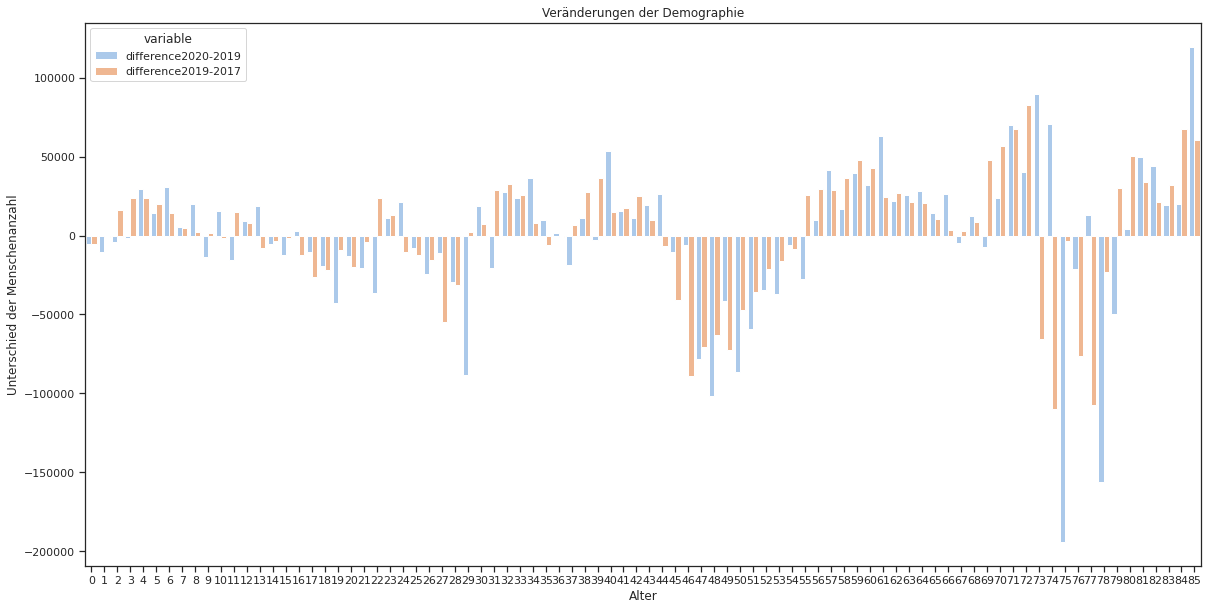

In [36]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
sns.barplot(data=population, y = 'value',x = 'age', hue = 'variable', palette = 'pastel')
plt.title("Veränderungen der Demographie")
plt.xlabel("Alter")
plt.ylabel("Unterschied der Menschenanzahl")
plt.show()

This Plot shows the demographic change of the mean of 2017 to 2019 and 2019 to 2020. 

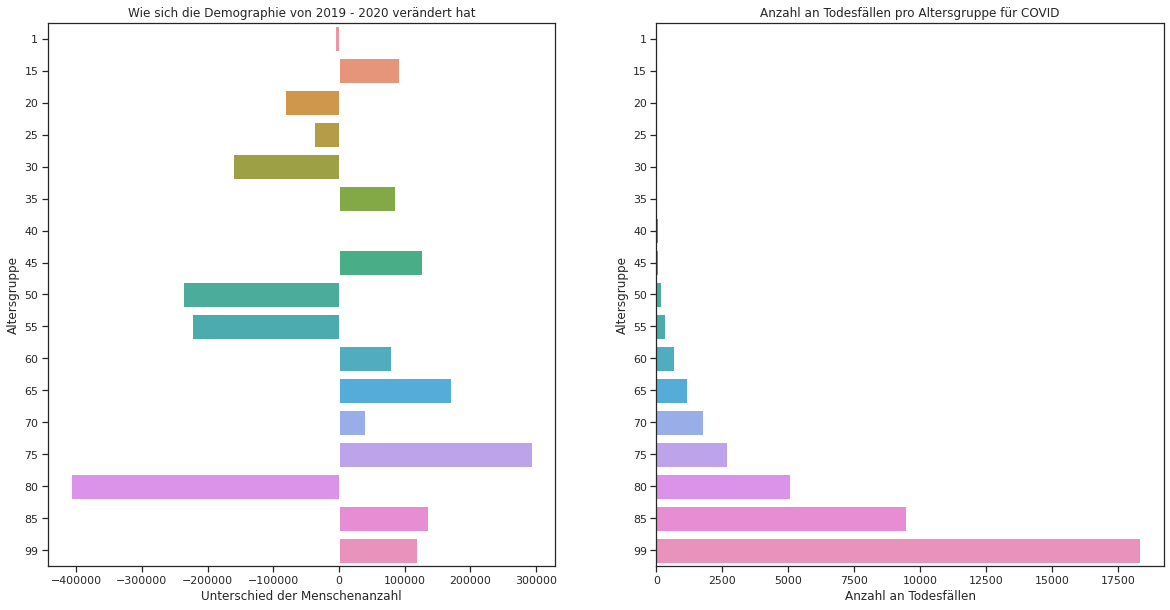

In [33]:
group_pop = population.groupby(['Altersgruppe', 'variable'])['value'].sum().reset_index()
stat_cleaned = stat_cleaned[(stat_cleaned["Todesursachen"].str.contains("COVID")) == False]

# get the 2017 - 2019 (2017-2019) and create new column
stat_total_cause =stat_cleaned[(stat_cleaned["Jahre"]== '2020') == False].groupby(["Altersgruppe", "Todesursachen"])["value"].sum().reset_index()
stat_total_cause["value"] = (stat_total_cause["value"]/3)
stat_total_cause = stat_total_cause.rename(columns ={"value": "2017 - 2019"})
stat_total_cause["2020"] = stat_cleaned[(stat_cleaned["Jahre"]== '2020') ].groupby(["Altersgruppe", "Todesursachen"])["value"].sum().reset_index()["value"]

# create column with the difference before and after covid
stat_total_cause["difference"] = stat_total_cause["2020"] - stat_total_cause["2017 - 2019"]


cd = stat_total_cause
stat_cleaned = clean_data(stat)
stat_cleaned = stat_cleaned[(stat_cleaned["Jahre"]== '2020') ]
stat_total_cov = stat_cleaned[stat_cleaned["Todesursachen" ].str.contains("COVID")].groupby([ "Altersgruppe"])["value"].sum().reset_index()
cd = stat_total_cov
#cd = cd[cd["difference"] != 0.0].reset_index()

# convert Altersgruppe to integer series
cd['Altersgruppe'] = cd['Altersgruppe'].str.replace(" Jahre", "")
cd['Altersgruppe'] = cd['Altersgruppe'].str.replace(" Jahr", "")
cd['Altersgruppe'] = cd['Altersgruppe'].str.replace("85 und mehr", "99")
cd['Altersgruppe'] = cd['Altersgruppe'].str.slice(start=-2).astype(int)

cd = cd.groupby('Altersgruppe')['value'].sum()

fig, ax = plt.subplots(1,2, figsize = (20,10))
fig.subplots_adjust(hspace=0.7)
# Plot how the demographics change from 2019 to 2020
sns.barplot(data = group_pop[group_pop['variable'] == 'difference2020-2019'], y = 'Altersgruppe', x = 'value', ax = ax[0], orient = 'h')
ax[0].set_title("Wie sich die Demographie von 2019 - 2020 verändert hat")
ax[0].set_xlabel("Unterschied der Menschenanzahl")
# Plot the total number of deaths per age group for COVID
sns.set_theme(style = "ticks", palette = "pastel")
chart = sns.barplot(data = stat_total_cov, y = "Altersgruppe",x = "value", ax = ax[1], orient = 'h')
ax[1].set_title("Anzahl an Todesfällen pro Altersgruppe für COVID")
ax[1].set_xlabel("Anzahl an Todesfällen")
plt.show()


Unsurprisingly, there are more older people dying from Covid. When looking at the left depiction one can see that the number of people in the age groups 75-85 is increasing even though the absolut number of deaths from covid is the highest for those age groups. One the left side the scale is displayed in 100000 steps and on the right side in 2500 steps. This implies that covid did not have a huge impact on the demographic change. 

# Final Words
In the beginning it seems like the total number of deaths increased due to covid. However, the total number of deaths of other causes seemed to have decreased which was probably due to the measures undertaken to prevent the spread of covid. When analysing the effect on the life expectancy we found some impact on the periodical life expectancy which is rather supceptible to short term changes which the cohort life excpectancy is not. Lastly, we looked at the effect on the demographics where we could not find any major impact. 